# Request Type
Command vs Question

In [10]:
import pandas as pd
import sqlite3
import os
import numpy as np


from helpers.normalization import remove_punctuation, remove_punctuation_and_newlines, remove_newlines
from helpers.statistical_tests import run_t_test_on_gender, compare_genders

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
prompts = pd.read_sql("SELECT ep.*, u.age, u.work_exp_years FROM expanded_prompts ep JOIN users u ON ep.user_id = u.user_id", conn)
prompts['conversational'] = prompts['conversational'].apply(remove_newlines)

In [11]:
prompts

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language,age,work_exp_years
0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,,Man (cisgender),6,en,19-25,3.0
1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en,19-25,3.0
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,,Man (cisgender),6,en,19-25,3.0
3,1135,55,user,what is FAISS,what is FAISS,,,Man (cisgender),6,en,19-25,3.0
4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en,19-25,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
748,1131,54,user,import pandas as pd\nimport numpy as np\nfrom ...,"I want to tune optimal thresholds. Currently, ...",import pandas as pd\nimport numpy as np\nfrom ...,The narratives list looks like this:\nnarrativ...,Man (cisgender),92,en,36-40,3.0
749,1532,71,user,"from transformers import AutoTokenizer, AutoMo...",I want to use an LLM for listwise reranking in...,"from transformers import AutoTokenizer, AutoMo...",,Man (cisgender),92,en,36-40,3.0
750,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en,36-40,3.0
751,1849,2,user,\n I am working on the problem of reconstru...,I am working on the problem of reconstruc...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en,19-25,1.0


## Set up LLM

In [12]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate

load_dotenv()

class OutputFormat(BaseModel):
    can_you_q: bool = Field(description="True, if the prompt is a 'can you' question")
    how_to_q: bool = Field(description="True, if the prompt is a 'how to' question")
    i_want: bool = Field(description="True, if the prompt is a 'i want' request")
    descriptive: bool = Field(description="True, if the prompt is a descriptive request")
    command: bool = Field(description="True, if the prompt is a command")
    comment: bool = Field(description="True, if the prompt is a comment of the output")
    other: bool = Field(description="True, if the prompt is neither of the categories")

system_prompt = SystemMessagePromptTemplate.from_template(
    "You are an assistant that helps categorize prompts."
)

user_prompt = HumanMessagePromptTemplate.from_template(
    """
    You are tasked with categorizing prompts into seven categories. The prompt is here for you to examine:
    ---
    {prompt}
    ---
    The prompt can belong into either of the following categories:
    1. Can-you-question: The user asks the llm to to a task by saying "Can you do xyz"
    2. How-to-question: The user asks the llm how a thing can be achieved by saying "How to xyz"
    3. I-want-request: The user asks the llm to do a task by saying "I want xyz"
    4. Descriptive: The user asks the llm to do a task by describing the desired output (e.g "The bar plot should have blue bars").
    5. Command: The user asks the llm to do a task by saying "Do xyz"
    6. Comment: The user comments on the previous output in a positive or negative manner (e.g "Cool", "This doesn't work").
    7. Other: The prompt fits neither of the above categories.

    A prompt may have aspects of multiple categories, for example: "Cool, can you also add xyz"
    Set all corresponding output fields to true.
    """,

input_variables=["prompt"]
)

complete_prompt = ChatPromptTemplate.from_messages([system_prompt, user_prompt])

def categorize_prompt(prompt):
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
    openai_model = "gpt-4o"
    llm = ChatOpenAI(temperature=0.0, model=openai_model)
    structured_llm = llm.with_structured_output(OutputFormat)

    print(f"evaluating next prompt")
    chain_one = (
            {"prompt": lambda x: x["prompt"]}
            | complete_prompt
            | structured_llm
            | {"can_you_q": lambda x: x.can_you_q,
               "how_to_q": lambda x: x.how_to_q,
               "i_want": lambda x: x.i_want,
               "descriptive": lambda x: x.descriptive,
               "command": lambda x: x.command,
               "comment": lambda x: x.comment,
               "other": lambda x: x.other,
               }
    )

    response =  chain_one.invoke({"prompt": prompt})

    return response["can_you_q"], response["how_to_q"], response["i_want"], response["descriptive"], response["command"], response["comment"], response["other"]

In [13]:
prompts[['can_you_q', 'how_to_q', 'i_want', 'descriptive', 'command', 'comment', 'other']] = prompts['conversational'].apply(lambda x: pd.Series(categorize_prompt(x)))

prompts

evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating next prompt
evaluating 

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,age,work_exp_years,can_you_q,how_to_q,i_want,descriptive,command,comment
0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,False,Man (cisgender),6,19-25,3.0,False,True,False,False,False,False
1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,False,Man (cisgender),6,19-25,3.0,False,False,False,True,True,False
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,False,Man (cisgender),6,19-25,3.0,False,False,False,True,True,False
3,1135,55,user,what is FAISS,what is FAISS,,True,Man (cisgender),6,19-25,3.0,False,False,False,False,False,False
4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,False,Man (cisgender),6,19-25,3.0,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",False,Man (cisgender),92,36-40,3.0,False,False,True,True,False,False
756,1845,37,user,\n nun möchte ich judgement balancing m...,nun möchte ich judgement balancing mi...,,False,Woman (cisgender),29,26-30,None,False,False,False,True,True,False
757,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,ich sehe keine veränderung im Plot. Was i...,,False,Woman (cisgender),29,26-30,None,False,False,False,False,False,True
758,1849,2,user,\n I am working on the problem of reconstru...,I am working on the problem of reconstruc...,,True,Man (cisgender),8,19-25,1.0,False,False,False,False,False,False


## Save to Database

In [33]:
prompts.to_sql('categorized_prompts', conn, if_exists='replace', index=False)

760

## Helpers

In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
import seaborn as sns
from helpers.occurences import count_occurrences


def count(df, group_name, word_types, word_lists):
    for word_type, word_list in zip(word_types, word_lists):
        for word in word_list:
            df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
        df[word_type] = df[word_list].sum(axis=1)
    df[group_name] = df[word_types].sum(axis=1)
    return df

gender_palette = {'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'}
age_palette = {'19-25': 'red', '26-30': 'orange', '31-35': 'yellow', '36-40': 'green', '41-50': 'blue', '51-60': 'purple'}


def box_plot(df, id_vars, bar_variables, x_label, y_label, hue_variable, palette):
    melted = df.melt(
    id_vars=id_vars,
    value_vars=bar_variables,
    var_name=x_label,
    value_name=y_label
)

    plt.figure(figsize=(8,6))
    sns.boxplot(
        data=melted,
        x=x_label,
        y=y_label,
        hue=hue_variable,
        palette=palette,
        width=0.7
    )

    plt.title(f'Counts and Scores by {hue_variable}')
    plt.ylabel('Average Proportion')
    plt.xlabel('Score/Count')
    plt.legend(title=hue_variable)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def groupwise_comparison_with_correction(df, columns):
    p_vals = []
    test_types = []
    female_vars = []
    male_vars = []
    nonzero_females = []
    nonzero_males = []
    for col in columns:
        p_value, test_type, female_var, male_var, nonzero_female, nonzero_male = compare_genders(df, col)
        p_vals.append(p_value)
        test_types.append(test_type)
        female_vars.append(female_var)
        male_vars.append(male_var)
        nonzero_females.append(nonzero_female)
        nonzero_males.append(nonzero_male)
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'word': columns,
        'test type': test_types,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'f_var': female_vars,
        'm_var': male_vars,
        'n_hits': [{'female': f, 'male': m} for f, m in zip(nonzero_females, nonzero_males)]
    })
    return results

def compute_anova(df, id_vars, value_vars, x_label, y_label):
    melted = df.melt(
    id_vars=id_vars,
    value_vars=value_vars,
    var_name=x_label,
    value_name=y_label
    )

    model = ols(f'{y_label} ~ gender * {x_label}', data=melted).fit()
    return sm.stats.anova_lm(model, typ=2)

def make_latex_table(df):
    return df.to_latex(index=False)

## Reimport

In [28]:
conn = sqlite3.connect(db_path)
prompts = pd.read_sql("SELECT * FROM categorized_prompts", conn)
prompts

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,age,...,we_question,boosters,greetings,anger,joy,neutral,please,thanks,surprise,scepticism
0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,0,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,0,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,0,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
3,1135,55,user,what is FAISS,what is FAISS,,1,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,0,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",0,Man (cisgender),92,36-40,...,0,0,0,0,0,1,0,0,0,0
756,1845,37,user,\n nun möchte ich judgement balancing m...,nun möchte ich judgement balancing mi...,,0,Woman (cisgender),29,26-30,...,0,0,0,0,0,1,0,0,0,0
757,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,ich sehe keine veränderung im Plot. Was i...,,0,Woman (cisgender),29,26-30,...,0,0,0,0,0,1,0,0,0,0
758,1849,2,user,\n I am working on the problem of reconstru...,I am working on the problem of reconstruc...,,1,Man (cisgender),8,19-25,...,0,0,0,0,0,1,0,0,0,0


## Manual annotation
interaction markers:
simple_dialog_markers: yes, no, okay, yeah, nope, nah ✅
Boosters: super, nice, great, good, amazing, perfect, totally ✅
greetings: hi, hey ✅
Politeness: please, thanks ✅
guidance: almost (at the beginning), better (at the beginning)
humor: lol, scherzo

Emotion:
surprise: ✅
scepticism: ✅
negative: ✅
positive: ✅
neutral: ✅


Question types:
you_question: can you, could you ✅
i_question: can i, do i, kann ich, faccio, mache ich, cant i, what are my, what is my, for me, i am, i do, i dont, should i, i also want ✅
We_question: can we, could we, können wir, shouldnt we ✅
unpersonal_question: how to, what is

Command Types
you_command: write a function, do xyz ✅
I_want_statement: i want, i need, i have to, i think, i have ✅
We_command: let's, we should, we need ✅
we_statement : we need, we should, we have to, wir müssen ✅
unpersonal_command: it should be like xyz

## Count Prompt Types per user

In [29]:
columns = ['unpersonal_question',
           'i_question',
           'can_you_question',
           'we_question',
           'unpersonal_command',
           'i_statement',
           'you_command',
           'we_command',
           'yes_no_okay',
           'greetings',
           'please',
           'thanks',
           'boosters',
           'joy',
           'neutral',
           'surprise',
           'scepticism',
           ]

user_means = (
    prompts.groupby(['user_id'])[columns].mean()
)
user_info_cols = ['gender','age', 'work_exp_years']
user_means = user_means.merge(
    prompts[['user_id'] + user_info_cols].drop_duplicates(),
    left_index=True, right_on='user_id'
)

user_means = user_means[user_means['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]

user_means

,unpersonal_question,i_question,can_you_question,we_question,unpersonal_command,i_statement,you_command,we_command,yes_no_okay,greetings,...,thanks,boosters,joy,neutral,surprise,scepticism,user_id,gender,age,work_exp_years
0,0.555556,0.111111,0.000000,0.111111,0.000000,0.111111,0.444444,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6,Man (cisgender),19-25,3.0
758,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,8,Man (cisgender),19-25,1.0
9,0.090909,0.090909,0.727273,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.090909,0.000000,1.000000,0.000000,0.000000,11,Woman (cisgender),26-30,1.0
20,0.666667,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,15,Man (cisgender),26-30,6.0
23,0.040000,0.320000,0.160000,0.000000,0.160000,0.480000,0.080000,0.000000,0.200000,0.000000,...,0.000000,0.080000,0.040000,0.960000,0.000000,0.000000,16,Woman (cisgender),19-25,None
48,0.750000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,25,Man (cisgender),26-30,6.0
52,0.090909,0.045455,0.318182,0.045455,0.090909,0.500000,0.045455,0.045455,0.227273,0.045455,...,0.181818,0.090909,0.090909,0.727273,0.045455,0.000000,28,Woman (cisgender),31-35,5.0
756,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,29,Woman (cisgender),26-30,None
75,0.400000,0.400000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,31,Man (cisgender),36-40,22.0
80,0.090909,0.136364,0.075758,0.000000,0.287879,0.045455,0.363636,0.030303,0.000000,0.000000,...,0.000000,0.015152,0.015152,0.924242,0.000000,0.121212,34,Man (cisgender),51-60,20.0


## Plot

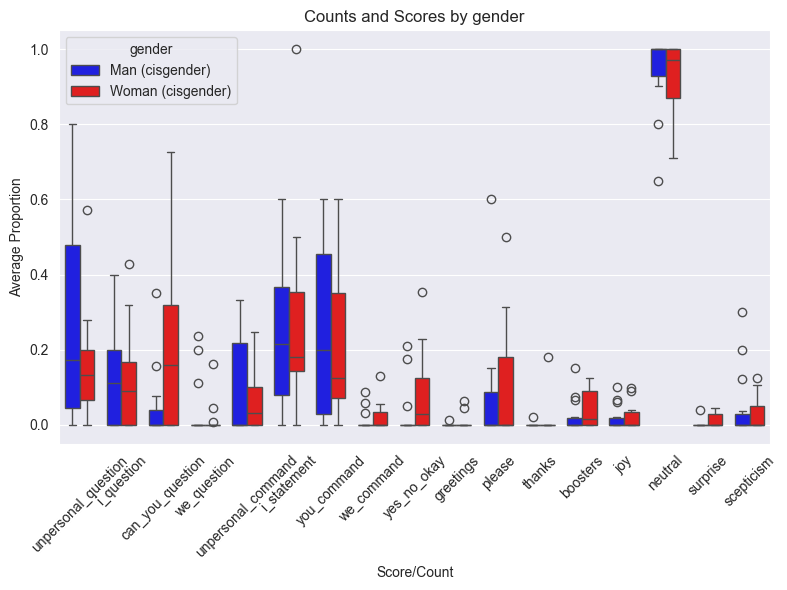

,word,test type,p_value,corrected p_value,f_var,m_var,n_hits
2,can_you_question,U-test,0.020672,0.351421,0.051456,0.009161,"{'female': 9, 'male': 5}"
8,yes_no_okay,U-test,0.076167,0.647417,0.012904,0.004643,"{'female': 7, 'male': 3}"
15,surprise,U-test,0.129177,0.732002,0.000280,0.000103,"{'female': 4, 'male': 1}"
12,boosters,U-test,0.201695,0.857206,0.002311,0.001856,"{'female': 7, 'male': 5}"
7,we_command,U-test,0.355388,1.000000,0.001429,0.000699,"{'female': 5, 'male': 3}"
10,please,U-test,0.374224,1.000000,0.025686,0.024200,"{'female': 6, 'male': 5}"
9,greetings,U-test,0.440153,1.000000,0.000423,0.000010,"{'female': 2, 'male': 1}"
14,neutral,U-test,0.483395,1.000000,0.012951,0.009838,"{'female': 13, 'male': 15}"
0,unpersonal_question,U-test,0.546905,1.000000,0.022865,0.081683,"{'female': 11, 'male': 11}"
4,unpersonal_command,U-test,0.752304,1.000000,0.005855,0.016593,"{'female': 8, 'male': 7}"


In [30]:
box_plot(user_means, ['user_id', 'gender'], columns, 'Prompt Type', 'Normalized Rate (per number of prompts)', 'gender', gender_palette)
overall_results = groupwise_comparison_with_correction(user_means, columns).sort_values(by="p_value", ascending=True)

overall_results
